In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

#Define beberapa Fungsi

In [134]:
def initWb(n_x, n_h, n_y):
    np.random.seed(1)    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2}
    
    return params    

###Inisialisasi weight dan bias
layer_dims = [input, hidden layer 1, hidden layer 2, ..., hidden layer n, output]

weight.shape = (l, l-1)

bias.shape = (l, 1)

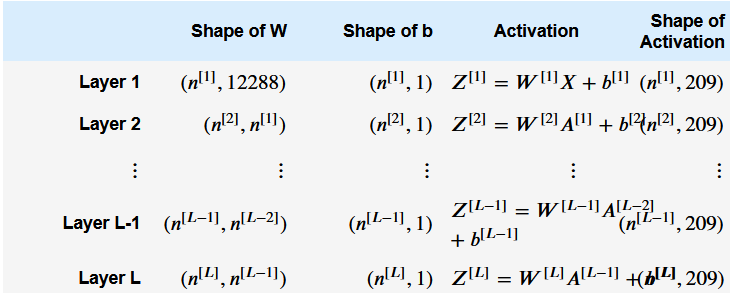

In [133]:
def initWbDeep(layer_dims):
    np.random.seed(1)
    params = {}
    L = len(layer_dims)

    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        params['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(params['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(params['b' + str(l)].shape == (layer_dims[l], 1))

        
    return params

###Forward Propagation

####Linear forward

In [135]:
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b # weighted sum
    cache = (A, W, b) # menyimpan input, weight, dan bias
    
    return Z, cache

####Sigmoid dan Relu forward

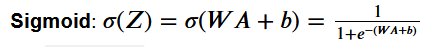

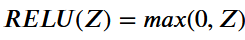

In [136]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 
    return A, cache

In [137]:
def activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache, activation_cache)

    return A, cache

####Model forward

In [138]:
def model_forward(X, params):
    caches = []
    A = X
    L = len(params) // 2 # banyak layer di jaringan
    
    # Looping untuk Linear -> Relu * (L-1)
    for l in range(1, L):
        A_prev = A 
        A, cache = activation_forward(A_prev, params["W"+str(l)], params["b"+str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = activation_forward(A, params["W"+str(L)], params["b"+str(L)], activation = "sigmoid")
    caches.append(cache)
          
    return AL, caches

####Hitung cost

In [139]:
def hitung_cost(AL, Y):
    m = Y.shape[1] # banyak data
    cost = -np.sum(np.multiply(np.log(AL), Y) + np.multiply(np.log(1-AL), (1-Y)))/m    
    cost = np.squeeze(cost) 

    return cost

###Backward Propagation

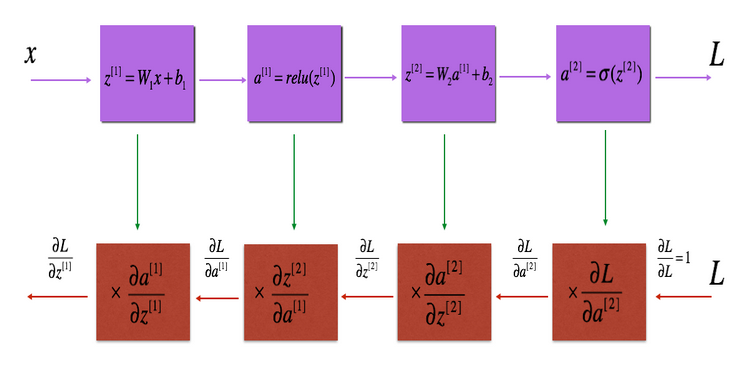

Warna ungu = forward, warna cokelat = backward.
**LINEAR->RELU->LINEAR->OUTPUT**

Langkah backward propagation:


1.   Linear backward
2.   Linear -> fungsi aktivasi', dimana fungsi aktivasi' adalah turunan dari fungsi aktivasi layer tersebut
3. [Linear -> Relu] * L-1 -> Linear -> Sigmoid backward



####Linear Backward

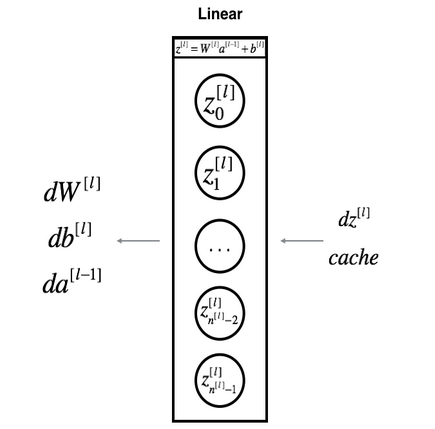

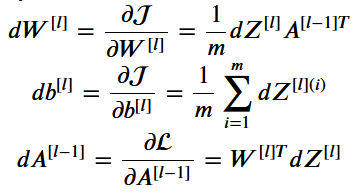

In [140]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

####Activation Backward

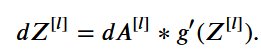

dA[l] * turunan fungsi aktivasi

In [141]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    return dZ

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    assert (dZ.shape == Z.shape)
    return dZ

In [142]:
def activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

####Model backward

In [143]:
def model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # banyak layer
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # turunan cost terhadap AL
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = activation_backward(dAL, current_cache, activation = "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Loop dari l=L-2 ke l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

####Update parameters

In [144]:
def optimize(params, grads, learning_rate):
    L = len(params) // 2 # banyaknya layer

    for l in range(L):
        params["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        params["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
        
    return params

In [145]:
def predict(X, y, params):
    m = X.shape[1]
    n = len(params) // 2
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = model_forward(X, params)

    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [146]:
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

##Deep Neural Network

In [147]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [148]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = 0. It's a non-cat picture.


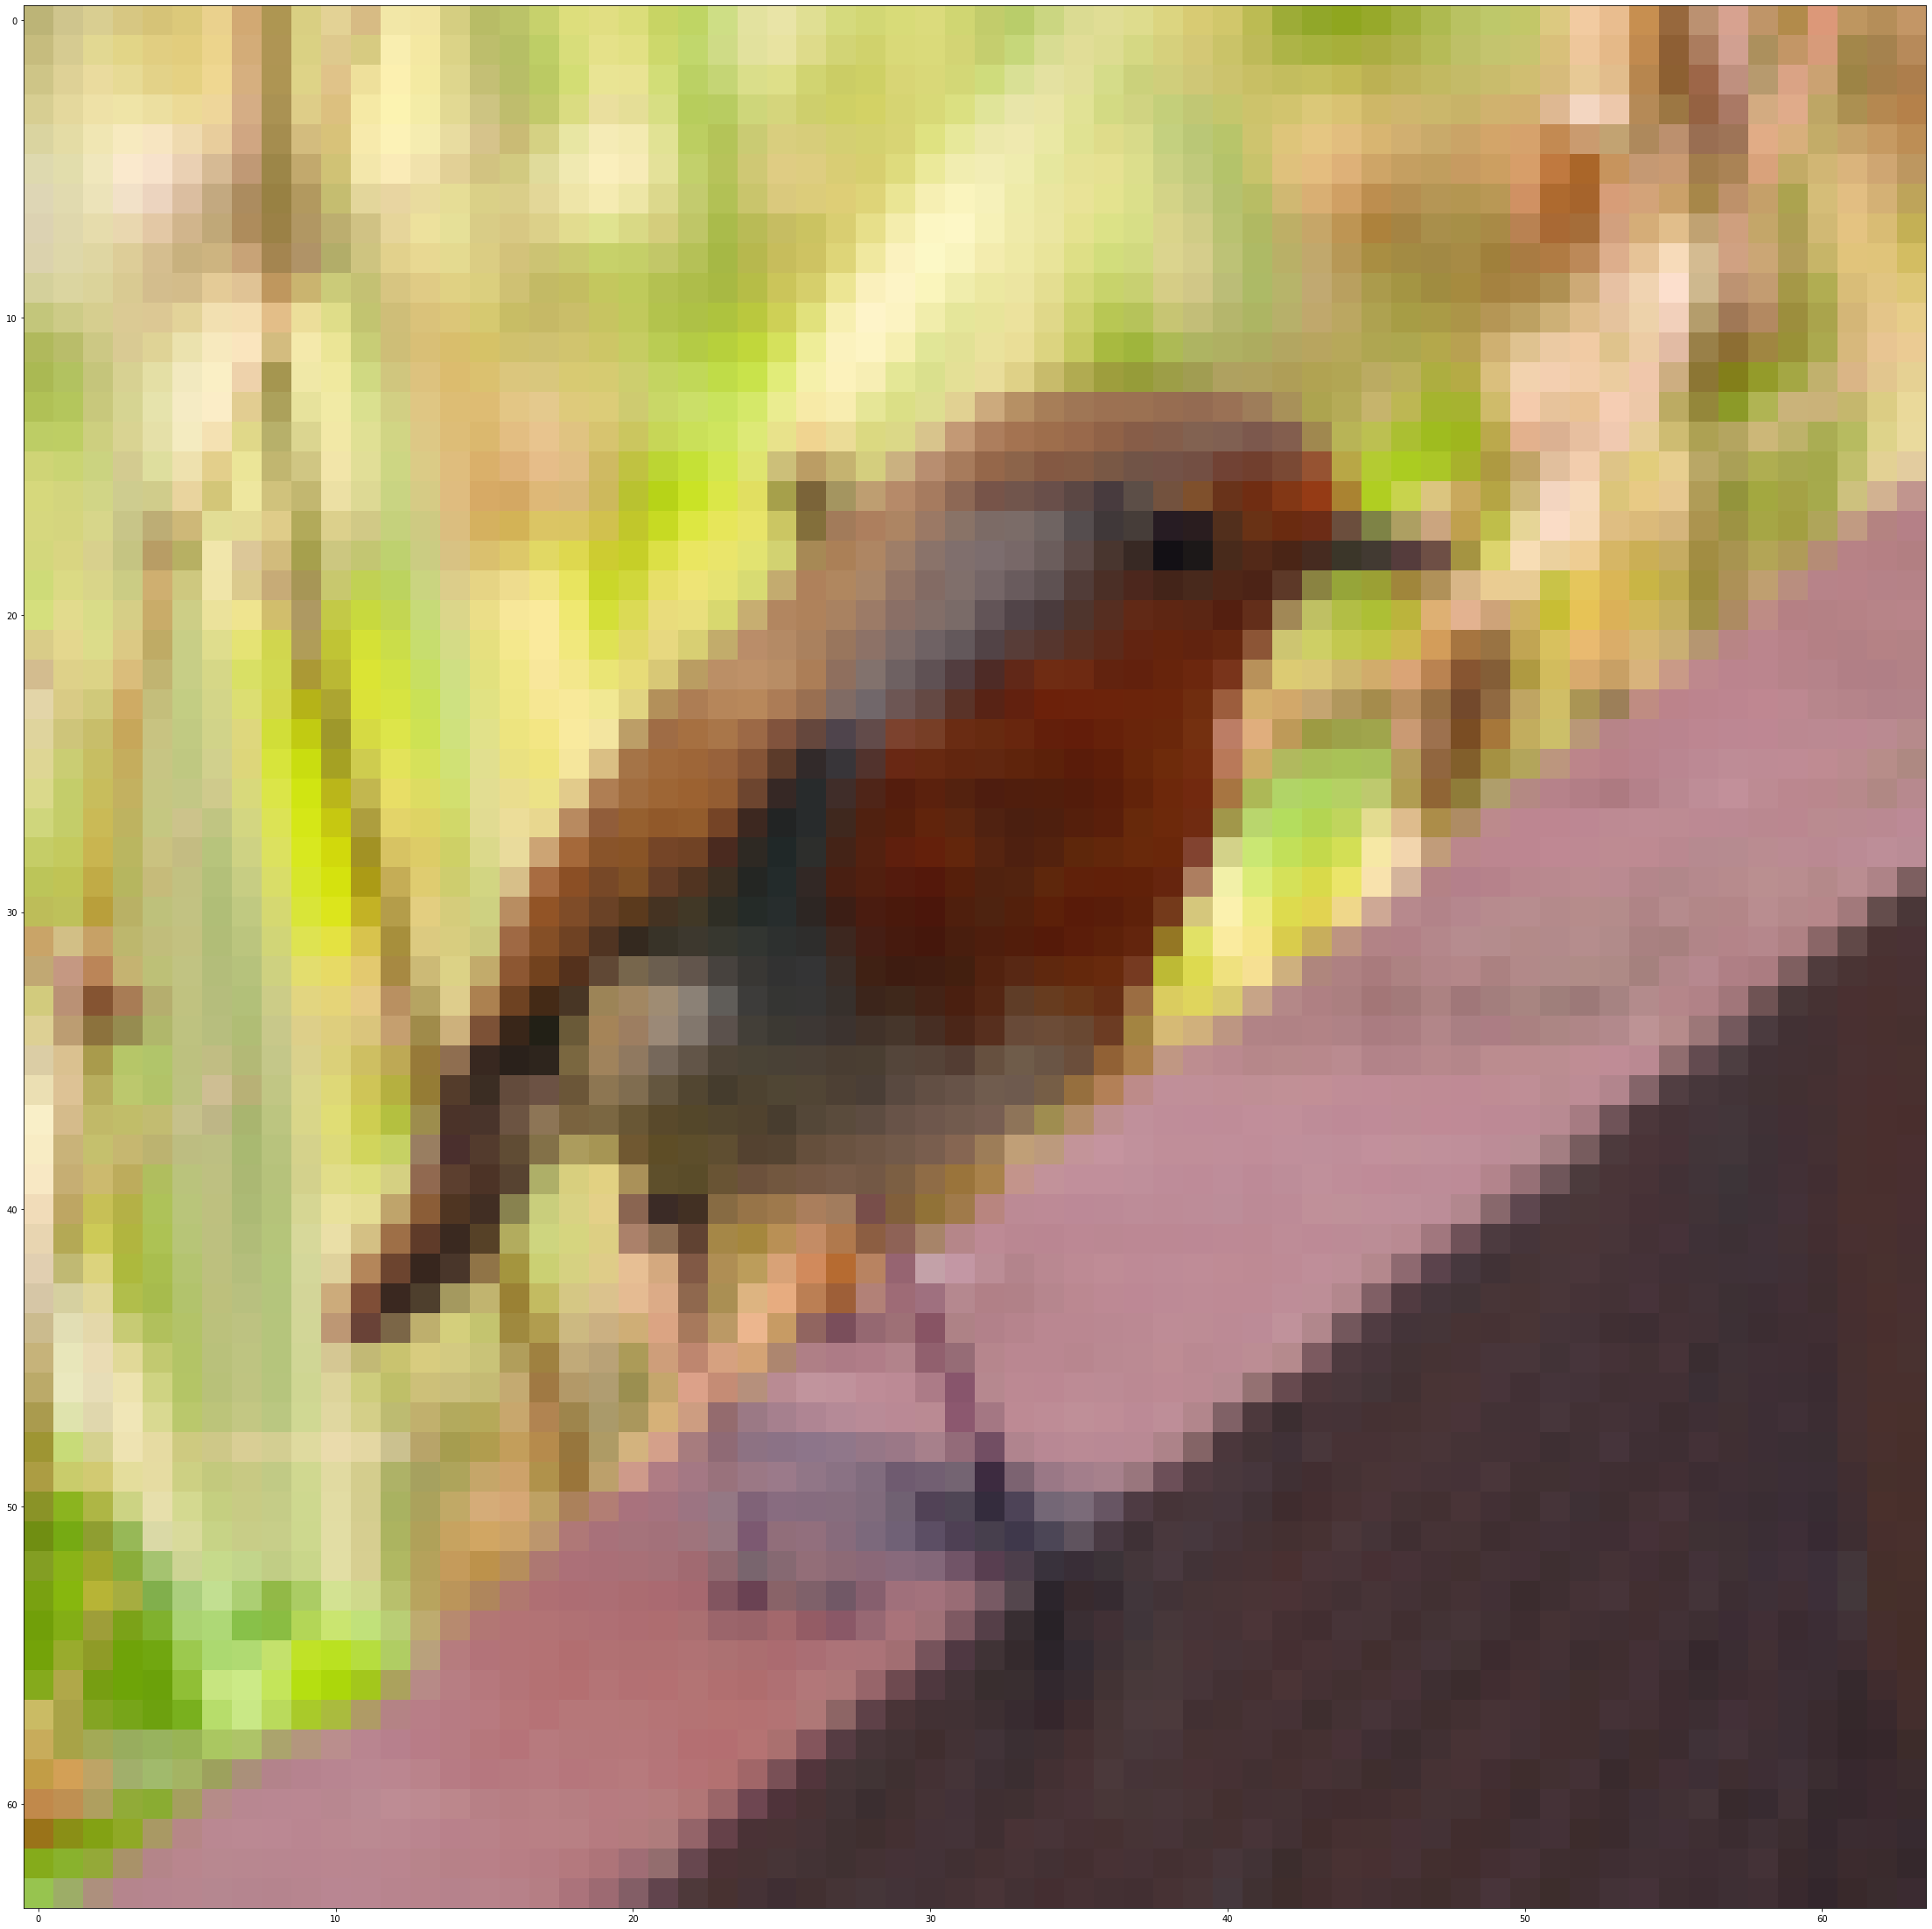

In [149]:
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [150]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Banyak data training = " + str(m_train))
print ("Banyak data testing = " + str(m_test))
print ("Dimensi: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("X_train shape: " + str(train_x_orig.shape))
print ("y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x_orig.shape))
print ("y_test shape: " + str(test_y.shape))

Banyak data training = 209
Banyak data testing = 50
Dimensi: (64, 64, 3)
X_train shape: (209, 64, 64, 3)
y_train shape: (1, 209)
X_test shape: (50, 64, 64, 3)
y_test shape: (1, 50)


In [151]:
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x shape: " + str(train_x.shape))
print ("test_x shape: " + str(test_x.shape))

train_x shape: (12288, 209)
test_x shape: (12288, 50)


###Model

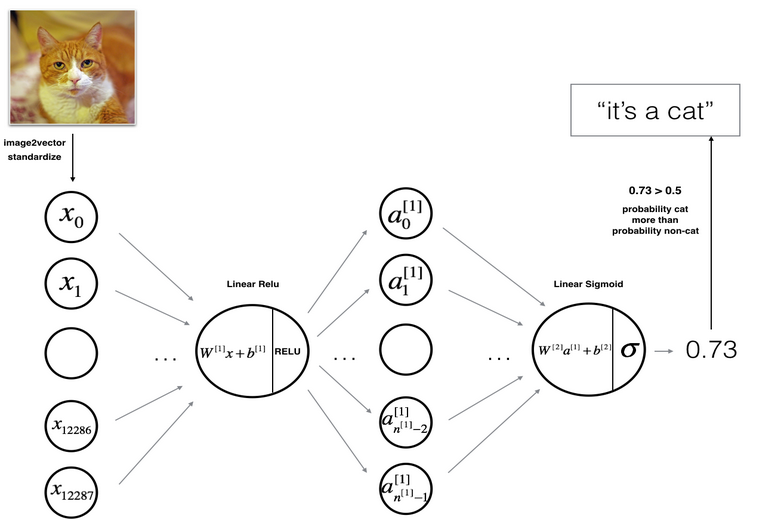

####Model 2 layer

In [152]:
n_x = 12288 # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [153]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, iterasi = 3000, print_cost=False):
    np.random.seed(1)
    grads = {}
    costs = []  
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims
    
    params = initWb(n_x, n_h, n_y)
    W1 = params["W1"]
    b1 = params["b1"]
    W2 = params["W2"]
    b2 = params["b2"]
    
    for i in range(0, iterasi):
        A1, cache1 = activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = activation_forward(A1, W2, b2, activation = "sigmoid")
        cost = hitung_cost(A2, Y)
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        dA1, dW2, db2 = activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = activation_backward(dA1, cache1, activation = "relu")
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        params = optimize(params, grads, learning_rate)
        
        W1 = params["W1"]
        b1 = params["b1"]
        W2 = params["W2"]
        b2 = params["b2"]
        
        if print_cost and i % 100 == 0 or i == iterasi - 1:
            print("Cost setelah iterasi %i: %f" % (i, cost))
        if i % 100 == 0 or i == iterasi:
            costs.append(cost)

    return params, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('Iterasi (per seribu)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Cost setelah iterasi 0: 0.693050
Cost setelah iterasi 100: 0.646432
Cost setelah iterasi 200: 0.632514
Cost setelah iterasi 300: 0.601502
Cost setelah iterasi 400: 0.560197
Cost setelah iterasi 500: 0.515830
Cost setelah iterasi 600: 0.475490
Cost setelah iterasi 700: 0.433916
Cost setelah iterasi 800: 0.400798
Cost setelah iterasi 900: 0.358071
Cost setelah iterasi 1000: 0.339428
Cost setelah iterasi 1100: 0.305275
Cost setelah iterasi 1200: 0.274914
Cost setelah iterasi 1300: 0.246818
Cost setelah iterasi 1400: 0.198507
Cost setelah iterasi 1500: 0.174483
Cost setelah iterasi 1600: 0.170808
Cost setelah iterasi 1700: 0.113065
Cost setelah iterasi 1800: 0.096294
Cost setelah iterasi 1900: 0.083426
Cost setelah iterasi 2000: 0.074391
Cost setelah iterasi 2100: 0.066307
Cost setelah iterasi 2200: 0.059193
Cost setelah iterasi 2300: 0.053361
Cost setelah iterasi 2400: 0.048555
Cost setelah iterasi 2499: 0.044215


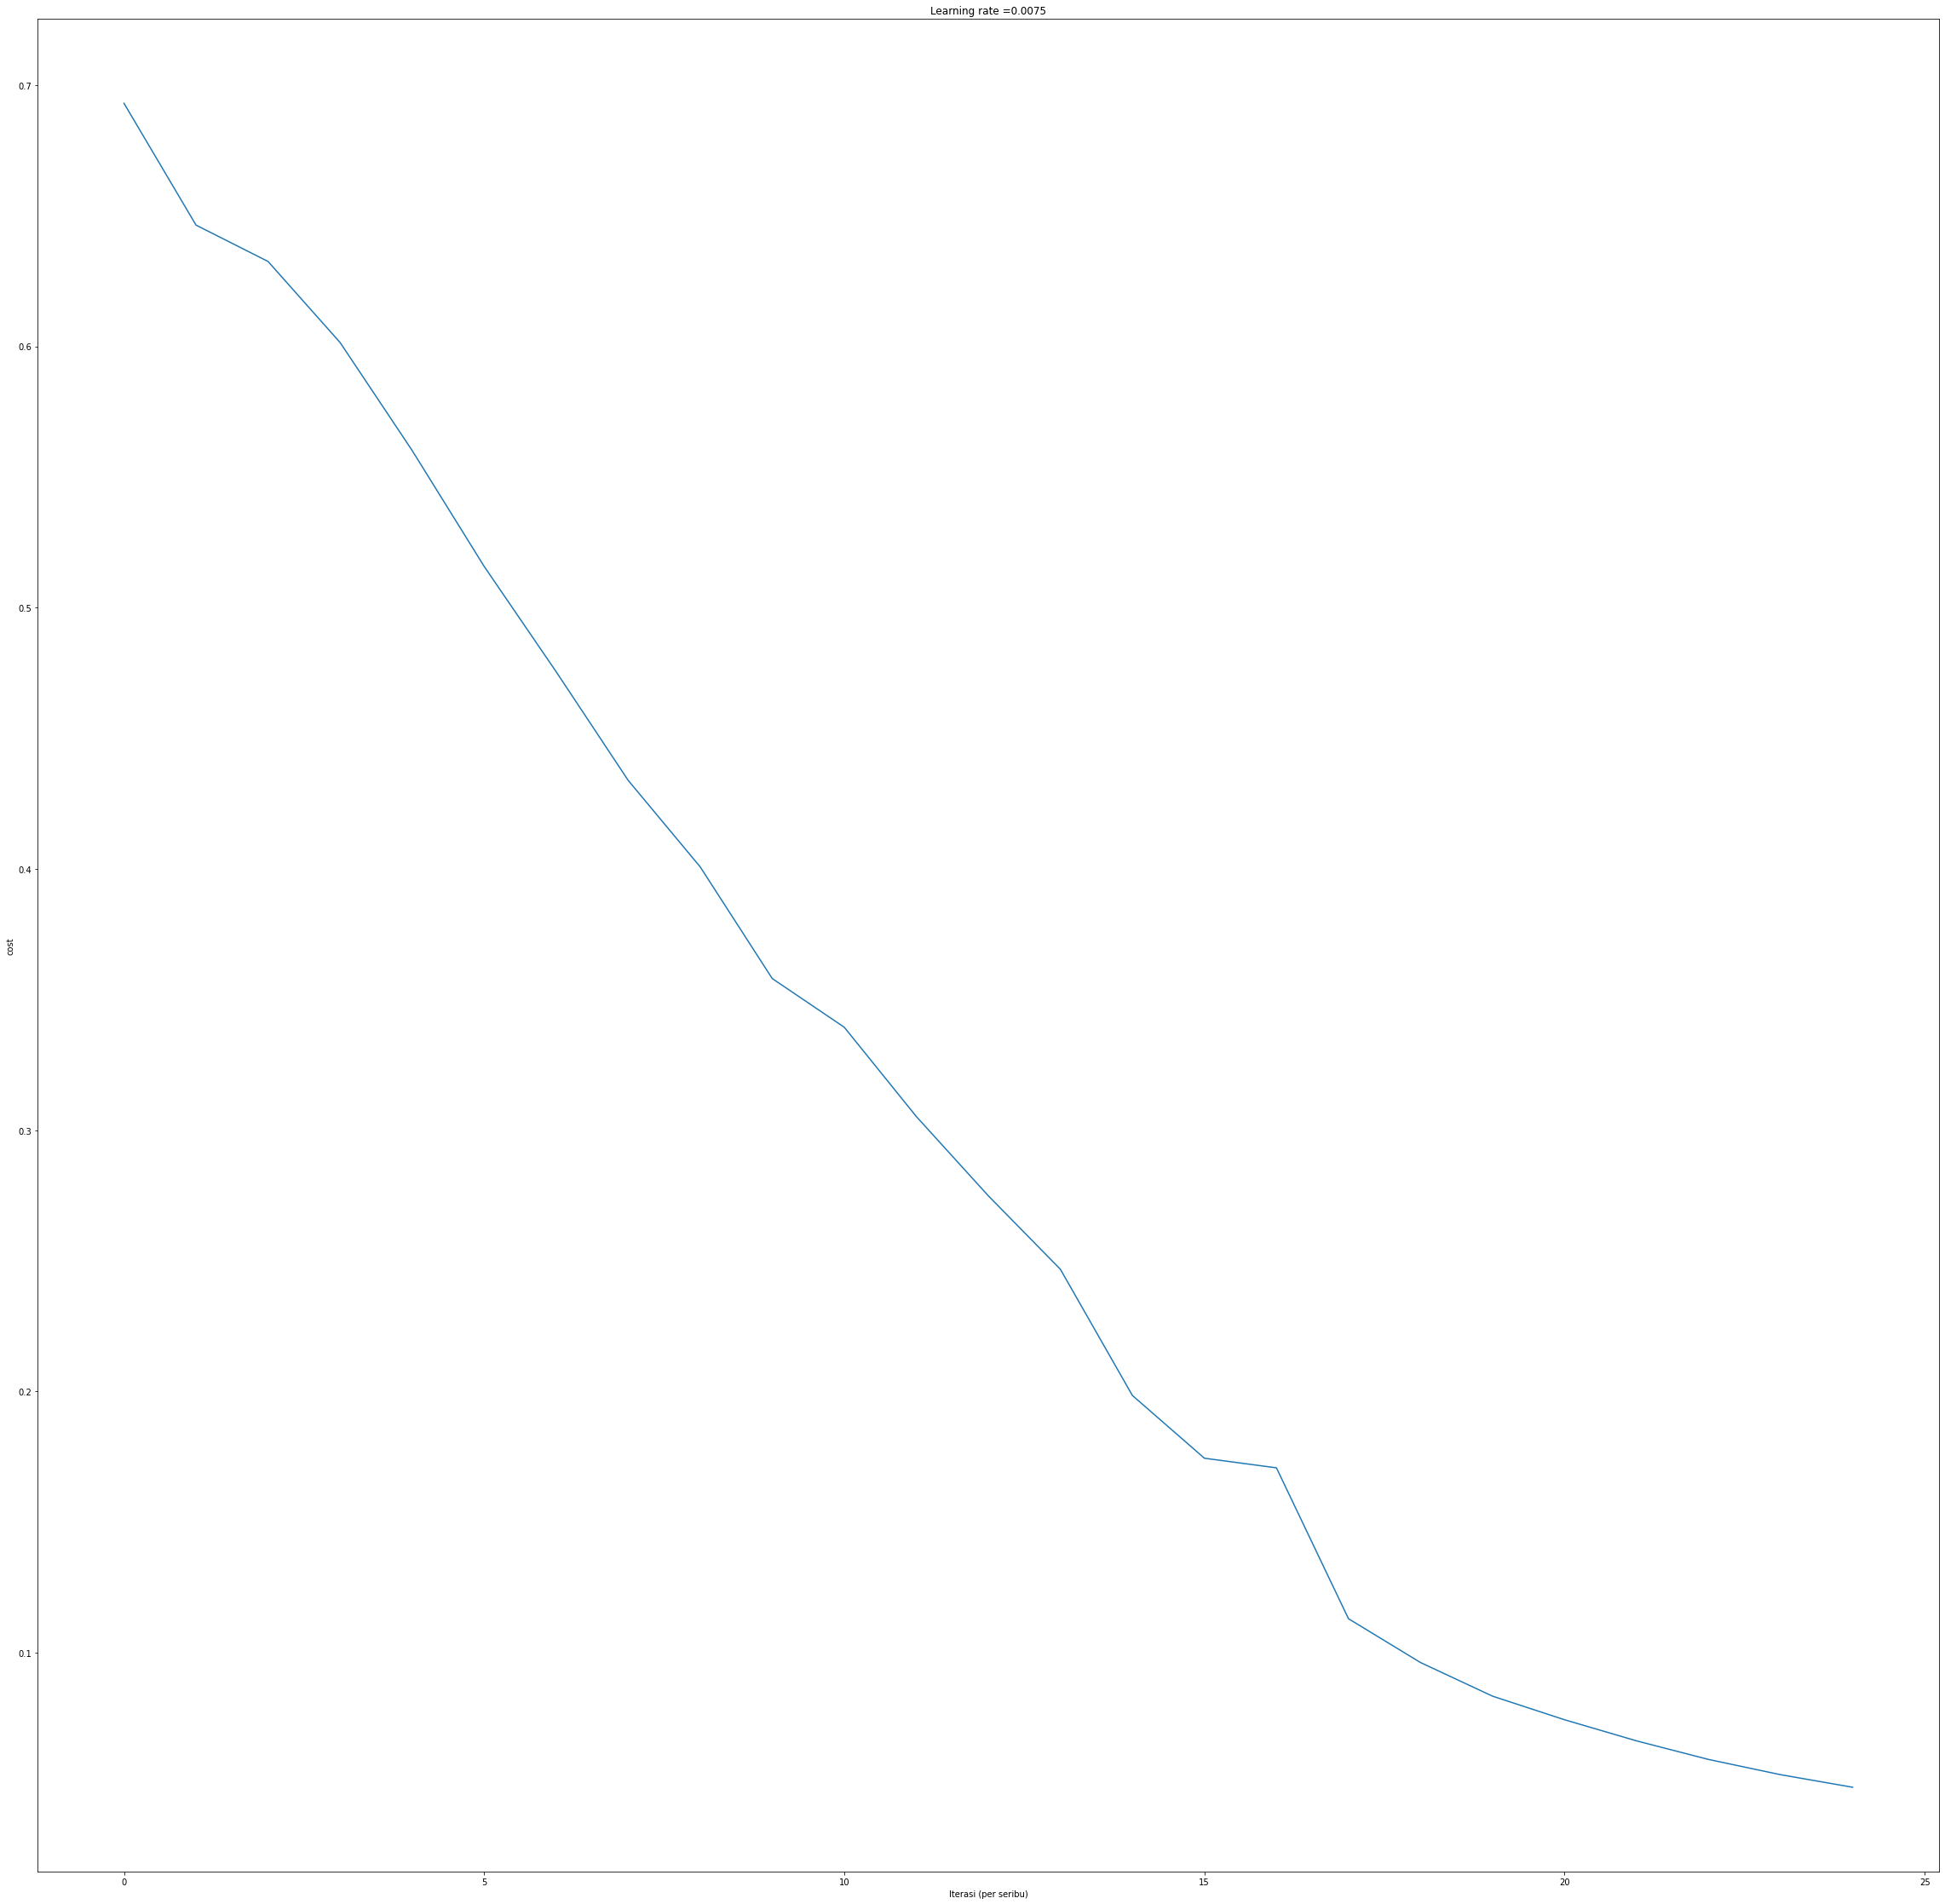

In [154]:
params, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), iterasi = 2500, print_cost=True)
plot_costs(costs, learning_rate)

In [155]:
predictions_train = predict(train_x, train_y, params)

Accuracy: 0.9999999999999998


In [156]:
predictions_test = predict(test_x, test_y, params)

Accuracy: 0.72


####Model 4 layer

In [157]:
layers_dims = [12288, 20, 7, 5, 1] #  4 layer model

In [158]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, iterasi = 3000, print_cost=False):
    np.random.seed(1)
    costs = []
    params = initWbDeep(layers_dims)
    
    for i in range(0, iterasi):
        AL, caches = model_forward(X, params)
        cost = hitung_cost(AL, Y)
        grads = model_backward(AL, Y, caches)
        params = optimize(params, grads, learning_rate)
        
        if print_cost and i % 100 == 0 or i == iterasi - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == iterasi:
            costs.append(cost)
    
    return params, costs

Cost after iteration 0: 0.7717493284237686
Cost after iteration 100: 0.6720534400822913
Cost after iteration 200: 0.6482632048575212
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.567047326836611
Cost after iteration 500: 0.5401376634547801
Cost after iteration 600: 0.5279299569455267
Cost after iteration 700: 0.46547737717668514
Cost after iteration 800: 0.369125852495928
Cost after iteration 900: 0.3917469743480535
Cost after iteration 1000: 0.31518698886006163
Cost after iteration 1100: 0.2726998441789384
Cost after iteration 1200: 0.2374185340026814
Cost after iteration 1300: 0.19960120532208644
Cost after iteration 1400: 0.18926300388463305
Cost after iteration 1500: 0.1611885466582775
Cost after iteration 1600: 0.14821389662363316
Cost after iteration 1700: 0.13777487812972944
Cost after iteration 1800: 0.1297401754919012
Cost after iteration 1900: 0.12122535068005214
Cost after iteration 2000: 0.1138206066863371
Cost after iteration 2100: 0.107839285262

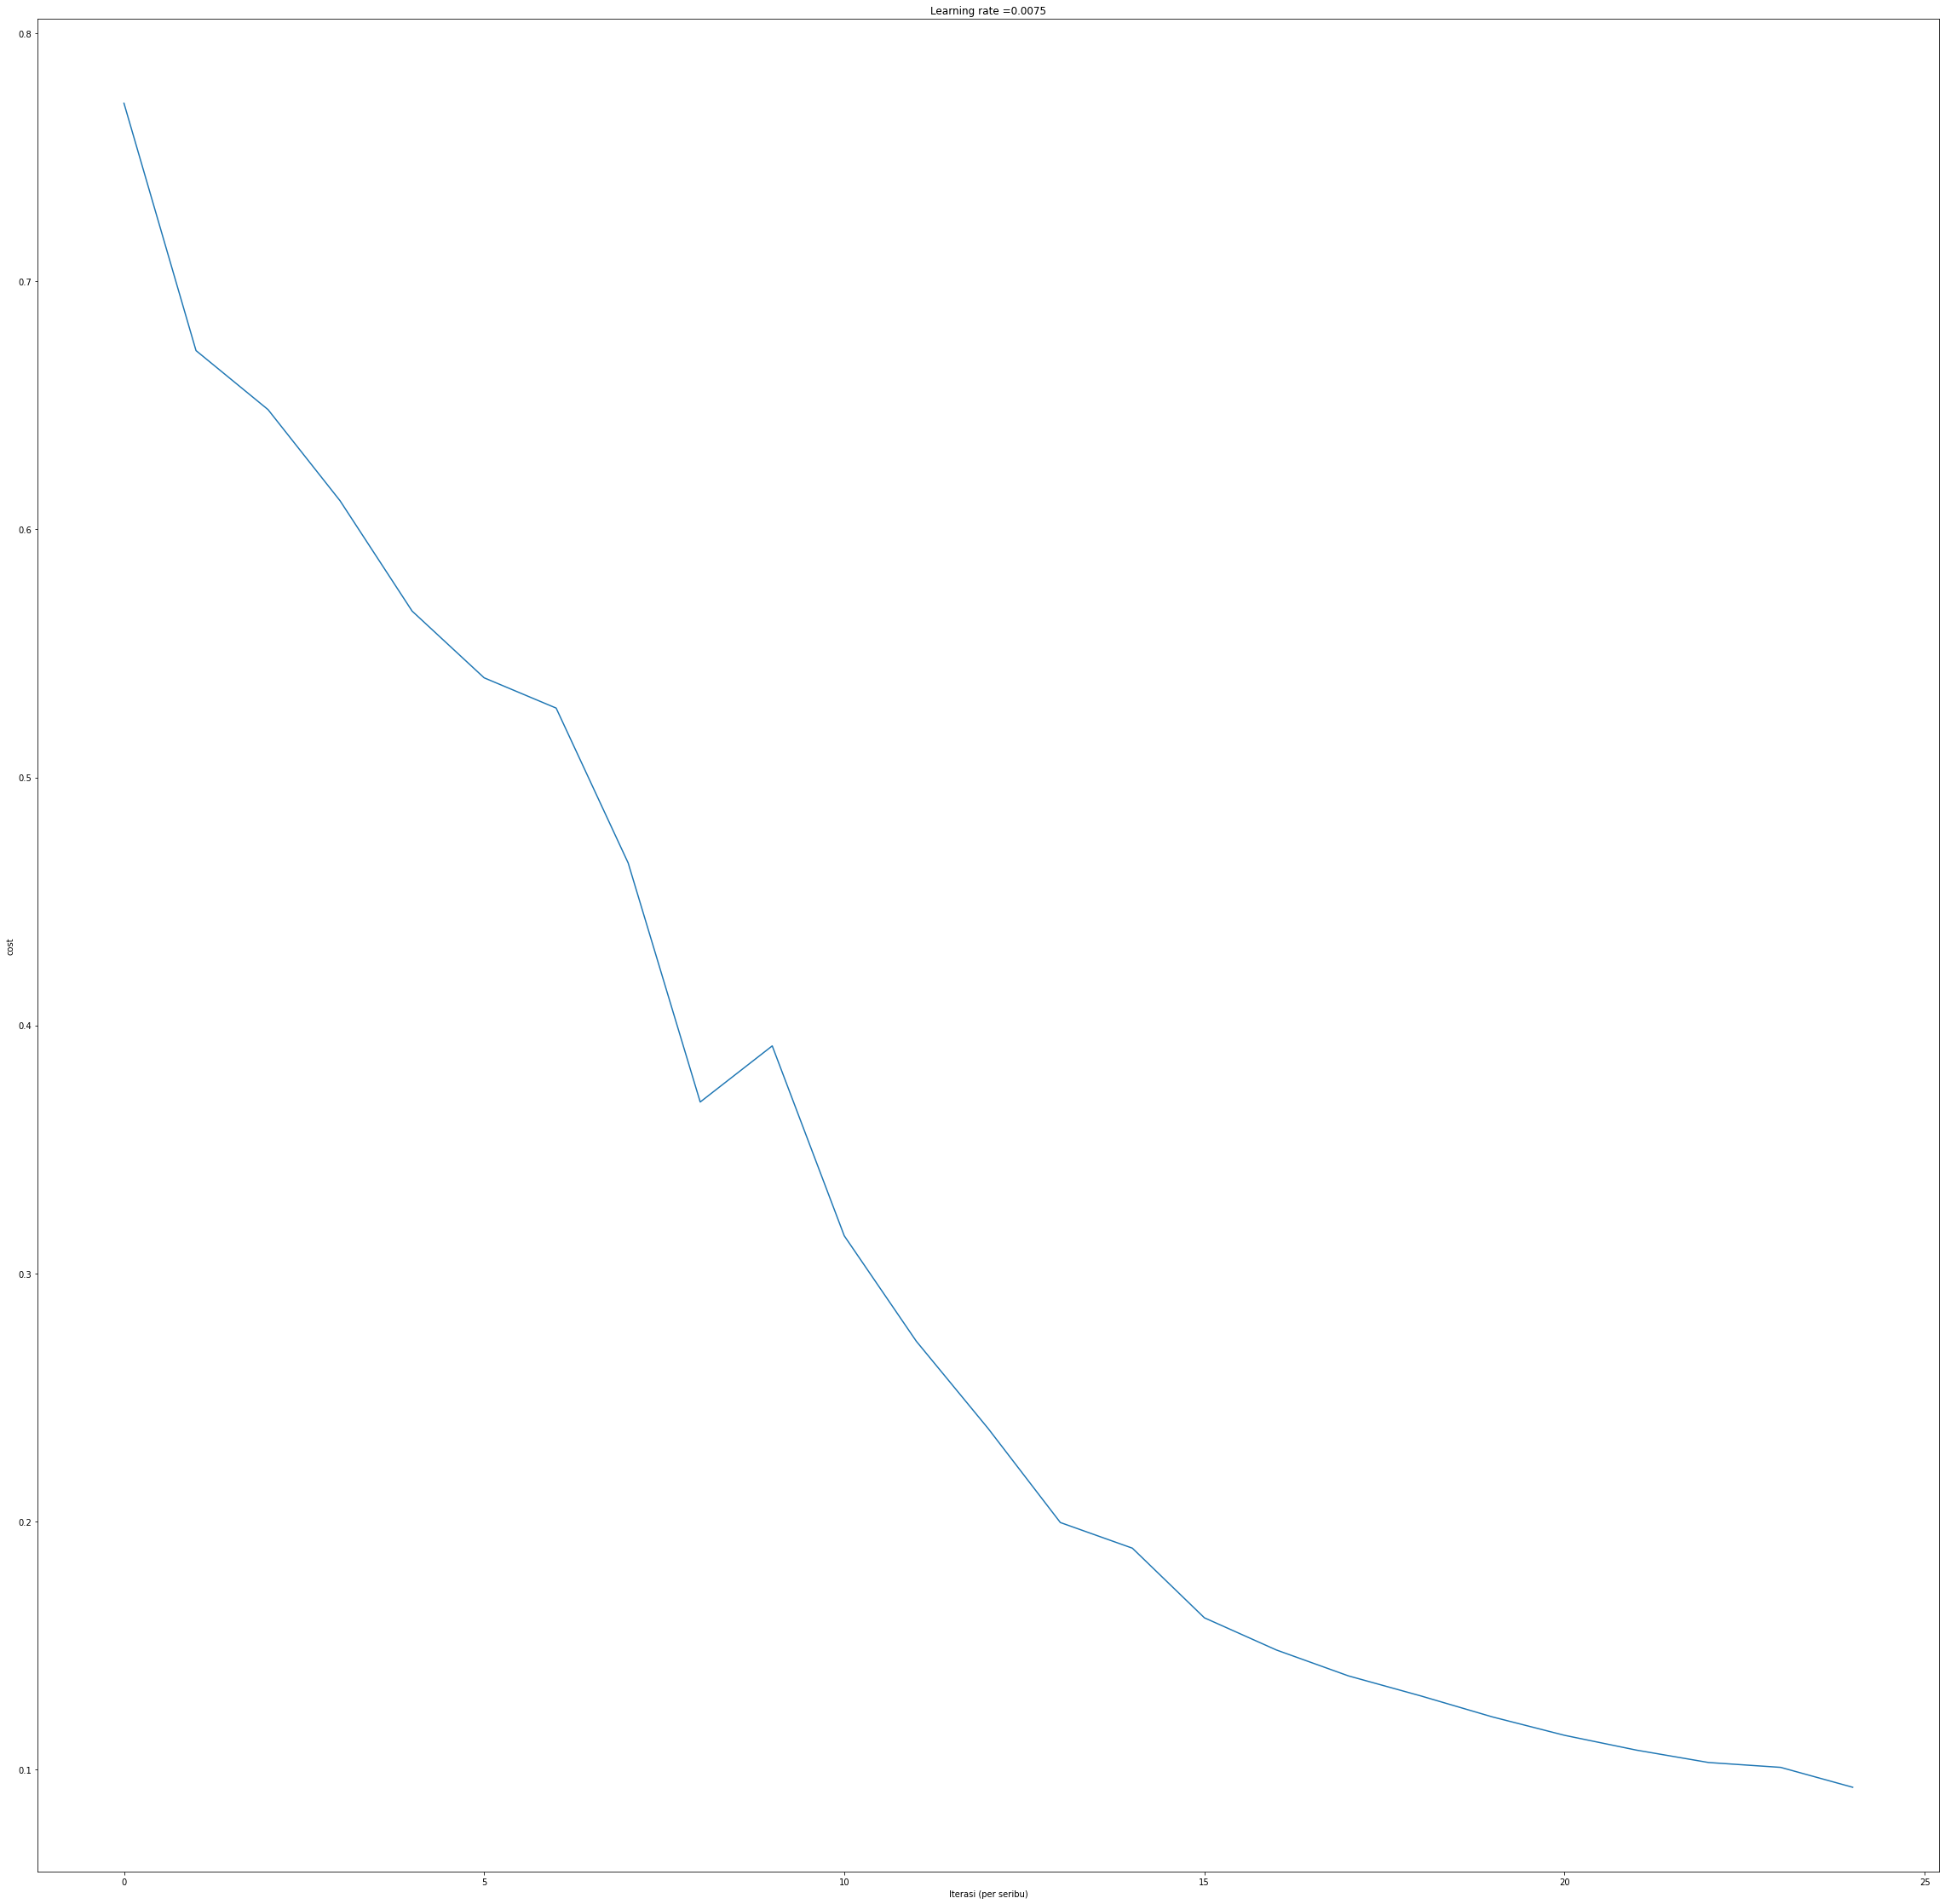

In [159]:
params, costs = L_layer_model(train_x, train_y, layers_dims, iterasi = 2500, print_cost = True)
plot_costs(costs, learning_rate)

In [160]:
pred_train = predict(train_x, train_y, params)

Accuracy: 0.9856459330143539


In [161]:
pred_test = predict(test_x, test_y, params)

Accuracy: 0.8


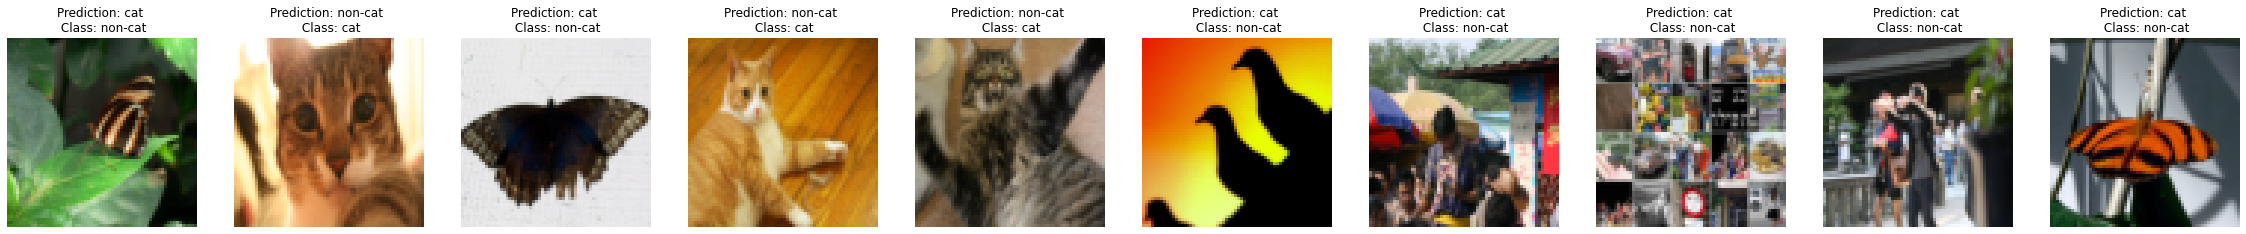

In [162]:
print_mislabeled_images(classes, test_x, test_y, pred_test)